In [2]:
import pandas as  pd
vehicle_data=pd.read_csv("vehicle_data.csv")
vehicle_data

,id,datasource,tank_capacity,rated_mpg
0,vehicle_1,source_1,18.0,35
1,vehicle_2,source_1,15.8,32
2,vehicle_3,source_2,15.8,24
3,vehicle_4,source_1,13.0,32
4,vehicle_5,source_2,23.0,22
5,vehicle_6,source_2,19.0,56
6,vehicle_7,source_2,23.0,21
7,vehicle_8,source_2,18.5,21
8,vehicle_9,source_1,17.9,24
9,vehicle_10,source_2,26.0,21


In [3]:
import pandas as  pd
import numpy as np

telemetry_1=pd.read_csv("telemetry_1.csv")

telemetry_2=pd.read_csv("telemetry_2.csv")

telemetry_2['speed'] = telemetry_2.apply(lambda row: row['val'] if row['name'] == 'speed' else np.nan, axis=1)
telemetry_2['odometer'] = telemetry_2.apply(lambda row: row['val'] if row['name'] == 'odometer' else np.nan, axis=1)
telemetry_2['fuel_level'] = telemetry_2.apply(lambda row: row['val'] if row['name'] == 'fuel_level' else np.nan, axis=1)

telemetry_2 = telemetry_2.drop(columns=['name', 'val'])

telemetry_1['timestamp'] = pd.to_datetime(telemetry_1['timestamp'], utc=True)
telemetry_2['timestamp'] = pd.to_datetime(telemetry_2['timestamp'], utc=True)

combined_telemetry = pd.merge(telemetry_1, telemetry_2, on=['vehicle_id', 'timestamp'], how='outer')

combined_telemetry['speed'] = combined_telemetry['speed_x'].combine_first(combined_telemetry['speed_y'])
combined_telemetry['odometer'] = combined_telemetry['odometer_x'].combine_first(combined_telemetry['odometer_y'])
combined_telemetry['fuel_level'] = combined_telemetry['fuel_level_x'].combine_first(combined_telemetry['fuel_level_y'])

# Drop the original '_x' and '_y' columns to clean up the DataFrame
combined_telemetry = combined_telemetry.drop(columns=[
    'speed_x', 'speed_y', 
    'odometer_x', 'odometer_y', 
    'fuel_level_x', 'fuel_level_y'
])
combined_telemetry

,vehicle_id,timestamp,speed,odometer,fuel_level
0,vehicle_4,2024-06-06 21:26:23+00:00,64.2,NaN,NaN
1,vehicle_8,2024-07-06 05:24:12.856000+00:00,1.6,12048.0,NaN
2,vehicle_3,2024-06-20 19:57:59.306000+00:00,NaN,NaN,45.0
3,vehicle_10,2024-07-25 01:04:23.776000+00:00,36.2,1434.7,NaN
4,vehicle_11,2024-07-06 18:08:03+00:00,29.5,NaN,NaN
...,...,...,...,...,...
834537,vehicle_11,2024-07-28 20:56:15+00:00,NaN,NaN,76.0
834538,vehicle_10,2024-07-15 14:48:22.493000+00:00,NaN,NaN,96.0
834539,vehicle_3,2024-07-06 15:13:40.007000+00:00,NaN,NaN,12.0
834540,vehicle_10,2024-07-18 21:02:34.694000+00:00,NaN,NaN,63.0


In [4]:
vehicle_groups = combined_telemetry.groupby('vehicle_id')
vehicle_dfs = {vehicle_id: vehicle_df for vehicle_id, vehicle_df in vehicle_groups}

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
fuel_economy_results = {}

# Iterate over each vehicle
for vehicle_id, vehicle_df in vehicle_dfs.items():
    # Step 1: Sort the DataFrame by timestamp
    vehicle_df = vehicle_df.sort_values(by='timestamp')
    
    # Step 2: Drop rows with NaN odometer values and calculate distance traveled
    vehicle_non_nan_odometer = vehicle_df.dropna(subset=['odometer'])
    vehicle_non_nan_odometer['distance_traveled'] = vehicle_non_nan_odometer['odometer'].diff().fillna(0)
    total_distance_covered = vehicle_non_nan_odometer['distance_traveled'].sum()
    
    # Step 3: Drop rows with NaN fuel_level values and calculate fuel level difference
    vehicle_non_nan_fuel = vehicle_df.dropna(subset=['fuel_level'])
    vehicle_non_nan_fuel['fuel_level_diff'] = vehicle_non_nan_fuel['fuel_level'].diff().fillna(0)
    
    # Step 4: Identify where fuel was consumed (fuel level dropped)
    vehicle_non_nan_fuel['is_fuel_consumed'] = vehicle_non_nan_fuel['fuel_level_diff'] < 0
    vehicle_non_nan_fuel['fuel_consumed'] = 0 
    
    # Step 5: Calculate fuel consumed based on fuel level drop 
    tank_capacity = vehicle_data[vehicle_data['id'] == vehicle_id]['tank_capacity'].values[0]
    fuel_drop_condition = vehicle_non_nan_fuel['is_fuel_consumed']
    vehicle_non_nan_fuel.loc[fuel_drop_condition, 'fuel_consumed'] = (
        tank_capacity * (-vehicle_non_nan_fuel['fuel_level_diff'] / 100)
    )
    total_fuel_consumed = vehicle_non_nan_fuel['fuel_consumed'].sum()

    # Step 6: Calculate fuel economy (MPG)
 
    fuel_economy_mpg = total_distance_covered / total_fuel_consumed


    vehicle_non_nan_speed = vehicle_df.dropna(subset=['speed'])
    avg_speed = vehicle_non_nan_speed['speed'].mean()
    # Step 8: Store results for the vehicle
    fuel_economy_results[vehicle_id] = {
        'total_distance_covered': total_distance_covered,
        'total_fuel_consumed': total_fuel_consumed,
        'fuel_economy_mpg': fuel_economy_mpg,
        'average_speed': avg_speed
    }

In [14]:
# Convert the original fuel_economy_results dictionary directly into a DataFrame
df_fuel_economy_direct = pd.DataFrame.from_dict(fuel_economy_results, orient='index').reset_index()
df_fuel_economy_direct.columns = ['Vehicle ID', 'Total Distance Covered (miles)', 'Total Fuel Consumed (gallons)', 
                                  'Fuel Economy (MPG)', 'Average Speed (mph)']


In [15]:
df_fuel_economy_direct

,Vehicle ID,Total Distance Covered (miles),Total Fuel Consumed (gallons),Fuel Economy (MPG),Average Speed (mph)
0,vehicle_1,29493.0,1074.060,27.459360,51.201690
1,vehicle_10,1706.9,7760.740,0.219940,20.648638
2,vehicle_11,24068.0,848.700,28.358666,49.291601
3,vehicle_2,11811.0,310.154,38.081082,49.141881
4,vehicle_3,7316.1,508.602,14.384725,24.222728
5,vehicle_4,8225.0,280.410,29.332049,38.260339
6,vehicle_5,4048.2,262.430,15.425828,28.042438
7,vehicle_6,4912.6,297.160,16.531835,35.592375
8,vehicle_7,4464.6,276.690,16.135748,29.127092
9,vehicle_8,4427.7,488.400,9.065725,25.627972


### Approach to Calculate Fuel Economy

The approach to calculate fuel economy (MPG) for each vehicle involves several steps. First, the telemetry data for each vehicle is sorted by the timestamp to ensure chronological order. Then, rows with missing odometer values are removed, and the **distance traveled** is calculated as the difference between consecutive odometer readings. This gives us the total distance covered by each vehicle. Next, rows with missing fuel level values are dropped, and the **fuel level difference** is computed. The key step here is to identify fuel consumption events by checking when the fuel level drops (indicating fuel consumption, as opposed to refueling). Based on the vehicle's tank capacity and the percentage drop in fuel level, we calculate the **fuel consumed** for each drop event.

Once the total fuel consumed is determined, we compute the fuel economy (MPG) as the ratio of the total distance traveled to the total fuel consumed. The final results for each vehicle, including total distance covered, total fuel consumed, and fuel economy, are stored in a dictionary for further analysis or display.

In [10]:
df_combined = pd.merge(df_fuel_economy_direct, vehicle_data[['id', 'rated_mpg']], left_on='Vehicle ID', right_on='id')

# Create a third column with the difference between real MPG and rated MPG
df_combined['MPG Difference'] = df_combined['Fuel Economy (MPG)'] - df_combined['rated_mpg']

# Keep only relevant columns
df_mpg_comparison = df_combined[['Vehicle ID', 'Fuel Economy (MPG)', 'rated_mpg', 'MPG Difference']]


In [11]:
df_mpg_comparison

,Vehicle ID,Fuel Economy (MPG),rated_mpg,MPG Difference
0,vehicle_1,27.459360,35,-7.540640
1,vehicle_10,0.219940,21,-20.780060
2,vehicle_11,28.358666,35,-6.641334
3,vehicle_2,38.081082,32,6.081082
4,vehicle_3,14.384725,24,-9.615275
5,vehicle_4,29.332049,32,-2.667951
6,vehicle_5,15.425828,22,-6.574172
7,vehicle_6,16.531835,56,-39.468165
8,vehicle_7,16.135748,21,-4.864252
9,vehicle_8,9.065725,21,-11.934275


### Observations on Fuel Economy Differences

A stark difference in fuel economy for **vehicle_3**, **vehicle_10**, and **vehicle_6** can be explained by a combination of factors, particularly related to their **high average fuel level** and **low average odometer distance**.

#### For these vehicles:

- **High average fuel level** suggests that these vehicles were frequently refueled or driven with a full tank, but not enough fuel was consumed to match the rated miles per gallon (MPG).
- **Low average odometer readings** imply that these vehicles did not cover much distance compared to other vehicles. 

- **Lower average speed** can indicate either frequent stops or idling, which can reduce fuel efficiency.
As a result, their fuel economy appears worse than expected, possibly because they may have:

- Idled frequently
- Made short trips, causing inefficient fuel usage

This mismatch between real-world usage and rated MPG highlights how driving patterns and conditions impact actual fuel efficiency.

---


The small difference in fuel economy for vehicle_9—despite its relatively low odometer readings—can be explained by the fact that vehicle_9 still maintains a driving pattern closer to its rated MPG.

Efficient driving patterns: Although vehicle_9 may not have covered as much distance as some other vehicles, the trips it did take could have been efficient, without frequent idling or harsh driving conditions. This would allow it to achieve an MPG close to its rated value.

---

Vehicle 11 shows a slightly lower-than-expected fuel economy compared to its rated MPG. Despite covering a significant distance and maintaining a relatively high average fuel level and odometer readings, the actual MPG falls short by approximately 6.64 MPG. This could indicate that while the vehicle is used extensively, it might experience some inefficiencies such as less efficient driving patterns, or driving conditions that require more fuel than anticipated, leading to a lower fuel economy than its rated value.

---


Vehicle_2 is performing better than expected in terms of fuel economy because it has likely been driven efficiently, covering a significant distance (11811 miles) while maintaining a consistent speed(50kmph) which gives good mileage.The vehicle might have experienced fewer idle times, short trips, or inefficient driving patterns, leading to better-than-expected fuel performance.

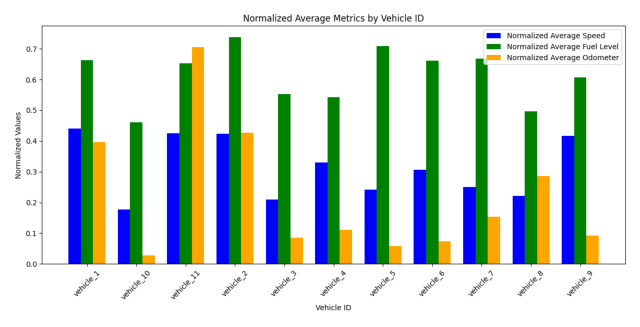

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('output.png')

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

## Detailed analysis for vehicle 1.

In [36]:
import pandas as  pd
import numpy as np

telemetry_1=pd.read_csv("telemetry_1.csv")

telemetry_2=pd.read_csv("telemetry_2.csv")

telemetry_2['speed'] = telemetry_2.apply(lambda row: row['val'] if row['name'] == 'speed' else np.nan, axis=1)
telemetry_2['odometer'] = telemetry_2.apply(lambda row: row['val'] if row['name'] == 'odometer' else np.nan, axis=1)
telemetry_2['fuel_level'] = telemetry_2.apply(lambda row: row['val'] if row['name'] == 'fuel_level' else np.nan, axis=1)

telemetry_2 = telemetry_2.drop(columns=['name', 'val'])

telemetry_1['timestamp'] = pd.to_datetime(telemetry_1['timestamp'], utc=True)
telemetry_2['timestamp'] = pd.to_datetime(telemetry_2['timestamp'], utc=True)

combined_telemetry = pd.merge(telemetry_1, telemetry_2, on=['vehicle_id', 'timestamp'], how='outer')

combined_telemetry['speed'] = combined_telemetry['speed_x'].combine_first(combined_telemetry['speed_y'])
combined_telemetry['odometer'] = combined_telemetry['odometer_x'].combine_first(combined_telemetry['odometer_y'])
combined_telemetry['fuel_level'] = combined_telemetry['fuel_level_x'].combine_first(combined_telemetry['fuel_level_y'])

# Drop the original '_x' and '_y' columns to clean up the DataFrame
combined_telemetry = combined_telemetry.drop(columns=[
    'speed_x', 'speed_y', 
    'odometer_x', 'odometer_y', 
    'fuel_level_x', 'fuel_level_y'
])
combined_telemetry

,vehicle_id,timestamp,speed,odometer,fuel_level
0,vehicle_4,2024-06-06 21:26:23+00:00,64.2,NaN,NaN
1,vehicle_8,2024-07-06 05:24:12.856000+00:00,1.6,12048.0,NaN
2,vehicle_3,2024-06-20 19:57:59.306000+00:00,NaN,NaN,45.0
3,vehicle_10,2024-07-25 01:04:23.776000+00:00,36.2,1434.7,NaN
4,vehicle_11,2024-07-06 18:08:03+00:00,29.5,NaN,NaN
...,...,...,...,...,...
834537,vehicle_11,2024-07-28 20:56:15+00:00,NaN,NaN,76.0
834538,vehicle_10,2024-07-15 14:48:22.493000+00:00,NaN,NaN,96.0
834539,vehicle_3,2024-07-06 15:13:40.007000+00:00,NaN,NaN,12.0
834540,vehicle_10,2024-07-18 21:02:34.694000+00:00,NaN,NaN,63.0


In [37]:
vehicle_groups = combined_telemetry.groupby('vehicle_id')
vehicle_dfs = {vehicle_id: vehicle_df for vehicle_id, vehicle_df in vehicle_groups}


In [38]:
vehicle_dfs["vehicle_1"]

,vehicle_id,timestamp,speed,odometer,fuel_level
11,vehicle_1,2024-04-25 06:03:44+00:00,NaN,15394.0,NaN
16,vehicle_1,2024-07-30 12:35:16+00:00,NaN,NaN,58.0
41,vehicle_1,2024-04-10 12:45:06+00:00,NaN,11192.0,NaN
55,vehicle_1,2024-03-26 12:56:30+00:00,NaN,9172.0,NaN
57,vehicle_1,2024-04-18 16:08:29+00:00,NaN,NaN,100.0
...,...,...,...,...,...
834518,vehicle_1,2024-03-29 11:15:23+00:00,NaN,NaN,100.0
834525,vehicle_1,2024-01-25 04:07:28+00:00,NaN,NaN,65.0
834533,vehicle_1,2024-03-25 13:23:12+00:00,NaN,NaN,51.0
834534,vehicle_1,2024-05-24 23:08:08+00:00,NaN,NaN,100.0


### sorting the data according to time stamp, earlier the data was converted into utc time for Standardization  

In [39]:
vehicle_dfs["vehicle_1"] = vehicle_dfs["vehicle_1"].sort_values(by='timestamp')
vehicle_dfs["vehicle_1"]

,vehicle_id,timestamp,speed,odometer,fuel_level
758435,vehicle_1,2024-01-02 15:20:03+00:00,NaN,466.0,NaN
97369,vehicle_1,2024-01-02 15:20:04+00:00,NaN,NaN,100.0
561274,vehicle_1,2024-01-02 15:20:22+00:00,0.0,NaN,NaN
56879,vehicle_1,2024-01-02 15:21:05+00:00,NaN,466.0,NaN
181554,vehicle_1,2024-01-02 15:21:06+00:00,NaN,NaN,100.0
...,...,...,...,...,...
662248,vehicle_1,2024-07-31 20:16:31+00:00,7.4,NaN,NaN
378365,vehicle_1,2024-07-31 20:17:14+00:00,NaN,NaN,74.0
769377,vehicle_1,2024-07-31 20:17:16+00:00,NaN,29959.0,NaN
357251,vehicle_1,2024-07-31 20:17:31+00:00,29.5,NaN,NaN


around 65k nan values, should we do Interpolation or drop?

both will have same effect in this case lets go with Interpolation

In [40]:
vehicle_dfs["vehicle_1"]['odometer'] = vehicle_dfs["vehicle_1"]['odometer'].interpolate(method='linear')


In [27]:
vehicle_1_non_nan=vehicle_dfs["vehicle_1"]

we calulate the difference between consecutive rows an add up to find total distance covered

In [28]:
vehicle_1_non_nan['distance_traveled'] = vehicle_1_non_nan['odometer'].diff()
vehicle_1_non_nan['distance_traveled'] = vehicle_1_non_nan['distance_traveled'].fillna(0)
total_distance_covered = vehicle_1_non_nan['distance_traveled'].sum()
print(f"Total distance covered by vehicle_1: {total_distance_covered} miles")



Total distance covered by vehicle_1: 29493.0 miles


In [41]:
tank_capacity_vehicle_1 = 18


In [42]:

# Create a copy of the DataFrame to avoid modifying the original
vehicle_1_non_nan_fuel = vehicle_dfs["vehicle_1"]

# Apply interpolation to 'fuel_level' column to fill missing values
vehicle_1_non_nan_fuel['fuel_level'] = vehicle_1_non_nan_fuel['fuel_level'].interpolate(method='linear')


In [43]:
vehicle_1_non_nan_fuel['fuel_level_diff'] = vehicle_1_non_nan_fuel['fuel_level'].diff()
vehicle_1_non_nan_fuel

,vehicle_id,timestamp,speed,odometer,fuel_level,fuel_level_diff
758435,vehicle_1,2024-01-02 15:20:03+00:00,NaN,466.0,NaN,NaN
97369,vehicle_1,2024-01-02 15:20:04+00:00,NaN,466.0,100.000000,NaN
561274,vehicle_1,2024-01-02 15:20:22+00:00,0.0,466.0,100.000000,0.000000
56879,vehicle_1,2024-01-02 15:21:05+00:00,NaN,466.0,100.000000,0.000000
181554,vehicle_1,2024-01-02 15:21:06+00:00,NaN,466.0,100.000000,0.000000
...,...,...,...,...,...,...
662248,vehicle_1,2024-07-31 20:16:31+00:00,7.4,29959.0,74.333333,-0.333333
378365,vehicle_1,2024-07-31 20:17:14+00:00,NaN,29959.0,74.000000,-0.333333
769377,vehicle_1,2024-07-31 20:17:16+00:00,NaN,29959.0,74.000000,0.000000
357251,vehicle_1,2024-07-31 20:17:31+00:00,29.5,29959.0,74.000000,0.000000


In [44]:
vehicle_1_non_nan_fuel['fuel_level_diff'] = vehicle_1_non_nan_fuel['fuel_level_diff'].fillna(0)
vehicle_1_non_nan_fuel

,vehicle_id,timestamp,speed,odometer,fuel_level,fuel_level_diff
758435,vehicle_1,2024-01-02 15:20:03+00:00,NaN,466.0,NaN,0.000000
97369,vehicle_1,2024-01-02 15:20:04+00:00,NaN,466.0,100.000000,0.000000
561274,vehicle_1,2024-01-02 15:20:22+00:00,0.0,466.0,100.000000,0.000000
56879,vehicle_1,2024-01-02 15:21:05+00:00,NaN,466.0,100.000000,0.000000
181554,vehicle_1,2024-01-02 15:21:06+00:00,NaN,466.0,100.000000,0.000000
...,...,...,...,...,...,...
662248,vehicle_1,2024-07-31 20:16:31+00:00,7.4,29959.0,74.333333,-0.333333
378365,vehicle_1,2024-07-31 20:17:14+00:00,NaN,29959.0,74.000000,-0.333333
769377,vehicle_1,2024-07-31 20:17:16+00:00,NaN,29959.0,74.000000,0.000000
357251,vehicle_1,2024-07-31 20:17:31+00:00,29.5,29959.0,74.000000,0.000000


we only want to calculate fuel consumption only for those rows where the fuel level dropped(<0).

In [45]:
vehicle_1_non_nan_fuel['is_fuel_consumed'] = vehicle_1_non_nan_fuel['fuel_level_diff'] < 0
vehicle_1_non_nan_fuel

,vehicle_id,timestamp,speed,odometer,fuel_level,fuel_level_diff,is_fuel_consumed
758435,vehicle_1,2024-01-02 15:20:03+00:00,NaN,466.0,NaN,0.000000,False
97369,vehicle_1,2024-01-02 15:20:04+00:00,NaN,466.0,100.000000,0.000000,False
561274,vehicle_1,2024-01-02 15:20:22+00:00,0.0,466.0,100.000000,0.000000,False
56879,vehicle_1,2024-01-02 15:21:05+00:00,NaN,466.0,100.000000,0.000000,False
181554,vehicle_1,2024-01-02 15:21:06+00:00,NaN,466.0,100.000000,0.000000,False
...,...,...,...,...,...,...,...
662248,vehicle_1,2024-07-31 20:16:31+00:00,7.4,29959.0,74.333333,-0.333333,True
378365,vehicle_1,2024-07-31 20:17:14+00:00,NaN,29959.0,74.000000,-0.333333,True
769377,vehicle_1,2024-07-31 20:17:16+00:00,NaN,29959.0,74.000000,0.000000,False
357251,vehicle_1,2024-07-31 20:17:31+00:00,29.5,29959.0,74.000000,0.000000,False


### Fuel Consumption Formula

Fuel Consumed (gallons) = Tank Capacity (gallons) × ( Fuel Level Drop (%) / 100 )

### Example:

- **Tank Capacity**: 18 gallons
- **Fuel Level at Time 1**: 100%
- **Fuel Level at Time 2**: 58%
- **Fuel Level Drop**: 100% - 58% = 42%

Fuel Consumed = 18 × (42 / 100) = 18 × 0.42 = 7.56 gallons

Thus, 7.56 gallons of fuel were consumed between the two timestamps.


In [46]:
# Step 3: Calculate fuel consumed based on fuel level drop, where fuel level has dropped
vehicle_1_non_nan_fuel['fuel_consumed'] = 0  # Initialize the column with 0

# Step 4: Calculate fuel consumed only for fuel level drops (where 'is_fuel_consumed' is True)
fuel_drop_condition = vehicle_1_non_nan_fuel['is_fuel_consumed']  # Filter for rows where fuel was consumed

vehicle_1_non_nan_fuel.loc[fuel_drop_condition, 'fuel_consumed'] = (
    tank_capacity_vehicle_1 * (-vehicle_1_non_nan_fuel['fuel_level_diff'] / 100)
)

# Step 5: Fill NaN values in the first row for fuel_consumed (since no previous fuel level exists to compare)
vehicle_1_non_nan_fuel['fuel_consumed'] = vehicle_1_non_nan_fuel['fuel_consumed'].fillna(0)
total_fuel_consumed = vehicle_1_non_nan_fuel['fuel_consumed'].sum()
total_fuel_consumed

1074.06

In [47]:
# Assuming total_distance_covered is already calculated
fuel_economy_mpg = total_distance_covered / total_fuel_consumed

print(f"Fuel Economy (MPG) for Vehicle 1: {fuel_economy_mpg} MPG")


Fuel Economy (MPG) for Vehicle 1: 27.459359812300992 MPG
